In [1]:
import os, sys
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
from cmocean import cm
from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.plot import *
import mitequinox.utils as ut

In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=10
                 )
#
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.0.220:33739' processes=70 threads=70, memory=1.09 TiB>

__________
# load Eta

In [46]:
D = '/dataref/ocean-analysis/intranet/LLC4320_surface/'
S = '/home/datawork-lops-osi/equinox/mit4320/diags/'

grd = ut.load_grd(['XC', 'YC', 'Depth', 'dxC', 'dyC', 'CS', 'SN'])
dsE = xr.open_zarr(D+'%s.zarr'%('Eta'))
ds = dsE.assign_coords(**grd.variables)
ds = ds.isel(face=10)
ds

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 10311)
Coordinates: (12/14)
    face     int64 10
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(200,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-11-15T14:00:00
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    ...       ...
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [11]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center

In [55]:
# sea level gradients
g = 9.81
dB_dx_raw = grid.diff(g*ds.Eta,'X')/ds.dxC 
dB_dy_raw = grid.diff(g*ds.Eta,'Y')/ds.dyC    
# interpolate back into (i,j) grids
dB_dx_raw_ij = grid.interp(dB_dx_raw,'X')
dB_dy_raw_ij = grid.interp(dB_dy_raw,'Y')
# rotation
dB_dx = dB_dx_raw_ij*ds.CS - dB_dy_raw_ij*ds.SN
dB_dy = dB_dx_raw_ij*ds.SN + dB_dy_raw_ij*ds.CS
# subdomain (California)
dEta_dx_california = dB_dx.isel(i=slice(2000,-1),j=slice(0,1000))
dEta_dy_california = dB_dy.isel(i=slice(2000,-1),j=slice(0,1000))
# save dEta/dx
dEta_dx_california = np.real(dEta_dx_california).rename('dEta_dx_california')
dEta_dx_california = dEta_dx_california.chunk({'time': 1,'i':2319,'j':1000}).drop(['CS','SN'])
dEta_dx_california.to_dataset().to_zarr(S+'dEta_dx_california.zarr', mode='w')  
# save dEta/dy
dEta_dy_california = np.real(dEta_dy_california).rename('dEta_dy_california')
dEta_dy_california = dEta_dy_california.chunk({'time': 1,'i':2319,'j':1000}).drop(['CS','SN'])
dEta_dy_california.to_dataset().to_zarr(S+'dEta_dy_california.zarr', mode='w')   

_______
# load sea level gradients

In [60]:
ds_Eta_x = xr.open_zarr(S+'dEta_dx_california.zarr')
ds_Eta_y = xr.open_zarr(S+'dEta_dy_california.zarr')
ds = xr.merge([ds_Eta_x, ds_Eta_y])
ds

<xarray.Dataset>
Dimensions:             (i: 2319, j: 1000, time: 10311)
Coordinates:
    Depth               (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    XC                  (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    YC                  (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    face                int64 10
  * i                   (i) int64 2000 2001 2002 2003 ... 4315 4316 4317 4318
  * j                   (j) int64 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * time                (time) datetime64[ns] 2011-09-13 ... 2012-11-15T14:00:00
Data variables:
    dEta_dx_california  (time, j, i) float32 dask.array<chunksize=(1, 1000, 2319), meta=np.ndarray>
    dEta_dy_california  (time, j, i) float32 dask.array<chunksize=(1, 1000, 2319), meta=np.ndarray>

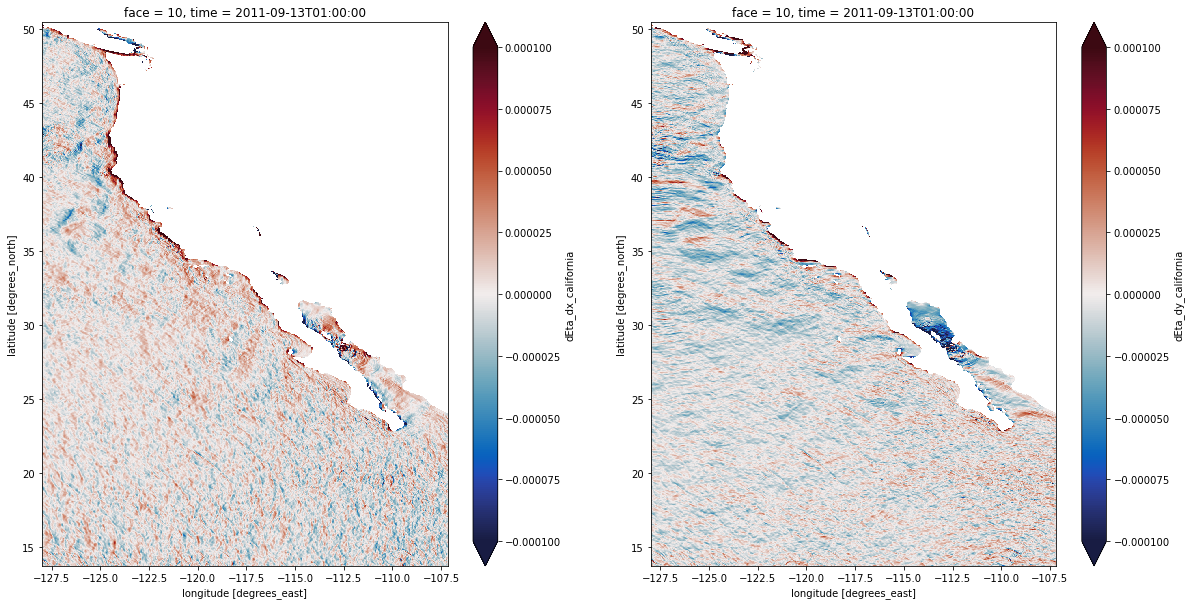

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.subplot(1,2,1)
ds.dEta_dx_california.isel(time=1).plot(x='XC',y='YC',vmin=-1e-4,vmax=1e-4,cmap=cm.balance)
ax = plt.subplot(1,2,2)
ds.dEta_dy_california.isel(time=1).plot(x='XC',y='YC',vmin=-1e-4,vmax=1e-4,cmap=cm.balance)

In [5]:
D = '/dataref/ocean-analysis/intranet/LLC4320_surface/'
S = '/home/datawork-lops-osi/equinox/mit4320/diags/'

grd = ut.load_grd(['XC', 'YC', 'Depth', 'dxC', 'dyC', 'CS', 'SN'])
dsU = xr.open_zarr(D+'%s.zarr'%('SSU'))
dsV = xr.open_zarr(D+'%s.zarr'%('SSV'))
dsE = xr.open_zarr(D+'%s.zarr'%('Eta'))
ds = (xr.merge([dsU,dsV, dsE], join='inner')
      .assign_coords(**grd.variables))
ds = ds.isel(face=10)
ds

<xarray.Dataset>
Dimensions:  (i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 8785)
Coordinates: (12/14)
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
    face     int64 10
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    (time) int64 dask.array<chunksize=(88,), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    ...       ...
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dxC      (j, i_g) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    dyC      (j_g, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
Data variables:
    SSU      (time, j, i_g) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    SSV      (time, j_g, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>
    Eta      (time, j, i) float32 dask.array<chunksize=(1, 4320, 4320), meta=np.ndarray>

In [8]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])

# sea level gradients
g = 9.81
dB_dx_raw = grid.diff(g*ds.Eta,'X')/ds.dxC 
dB_dy_raw = grid.diff(g*ds.Eta,'Y')/ds.dyC    
# interpolate back into (i,j) grids
dB_dx_raw_ij = grid.interp(dB_dx_raw,'X')
dB_dy_raw_ij = grid.interp(dB_dy_raw,'Y')
# rotation
dB_dx = dB_dx_raw_ij*ds.CS - dB_dy_raw_ij*ds.SN
dB_dy = dB_dx_raw_ij*ds.SN + dB_dy_raw_ij*ds.CS
# subdomain (California)
dEta_dy_california = dB_dy.isel(i=slice(2000,-1),j=slice(0,1000))
dEta_dy_california

<xarray.DataArray (time: 8785, j: 1000, i: 2319)>
dask.array<getitem, shape=(8785, 1000, 2319), dtype=float32, chunksize=(1, 999, 2319), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 991 992 993 994 995 996 997 998 999
  * i        (i) int64 2000 2001 2002 2003 2004 ... 4314 4315 4316 4317 4318
    face     int64 10
    XC       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>

In [9]:
U_ij = grid.interp(ds['SSU'],'X')
V_ij = grid.interp(ds['SSV'],'Y')

SSU_rotation = U_ij*ds.CS - V_ij*ds.SN
SSV_rotation = U_ij*ds.SN + V_ij*ds.CS
SSU_rotation = np.real(SSU_rotation).rename('SSU_rotation')
SSV_rotation = np.real(SSV_rotation).rename('SSV_rotation')


f = ut.coriolis(ds["YC"])
fv = SSV_rotation*f
fu = SSU_rotation*f
fu_california = fu.isel(i=slice(2000,-1),j=slice(0,1000))
fu_california

<xarray.DataArray (time: 8785, j: 1000, i: 2319)>
dask.array<getitem, shape=(8785, 1000, 2319), dtype=float32, chunksize=(1, 1000, 2319), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 991 992 993 994 995 996 997 998 999
  * i        (i) int64 2000 2001 2002 2003 2004 ... 4314 4315 4316 4317 4318
    face     int64 10
    XC       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>

In [10]:
SSU_rotation_california = SSU_rotation.isel(i=slice(2000,-1),j=slice(0,1000))
SSU_rotation_california

<xarray.DataArray 'SSU_rotation' (time: 8785, j: 1000, i: 2319)>
dask.array<getitem, shape=(8785, 1000, 2319), dtype=float32, chunksize=(1, 1000, 2319), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-11-15 2011-11-15T01:00:00 ... 2012-11-15
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 991 992 993 994 995 996 997 998 999
  * i        (i) int64 2000 2001 2002 2003 2004 ... 4314 4315 4316 4317 4318
    face     int64 10
    XC       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>

(-2.0, 2.0)

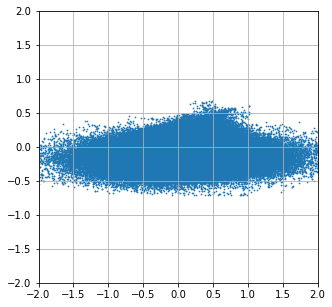

In [29]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter( -dEta_dy_california.where(dEta_dy_california.Depth>1000).isel(time=1)/f, SSU_rotation_california.where(dEta_dy_california.Depth>1000).isel(time=1), s=.5)
ax.grid()
ax.set_xlim(-2.,2.)
ax.set_ylim(-2.,2.)

(-1.0, 1.0)

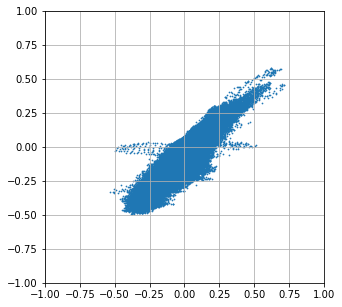

In [18]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter( -dEta_dy_california.where(dEta_dy_california.Depth>1000).isel(time=slice(0,24)).mean('time')/f, SSU_rotation_california.where(dEta_dy_california.Depth>1000).isel(time=slice(0,24)).mean('time'), s=.5)
ax.grid()
ax.set_xlim(-1.,1.)
ax.set_ylim(-1.,1.)

(-1.0, 1.0)

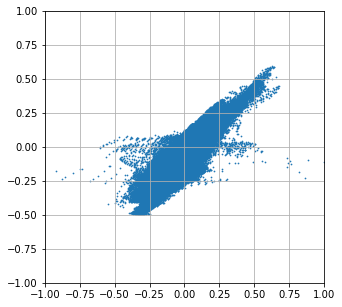

In [27]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter( -dEta_dy_california.where(dEta_dy_california.Depth>1000).isel(time=slice(0,48)).mean('time')/f, SSU_rotation_california.where(dEta_dy_california.Depth>1000).isel(time=slice(0,48)).mean('time'), s=.5)
ax.grid()
ax.set_xlim(-1.,1.)
ax.set_ylim(-1.,1.)

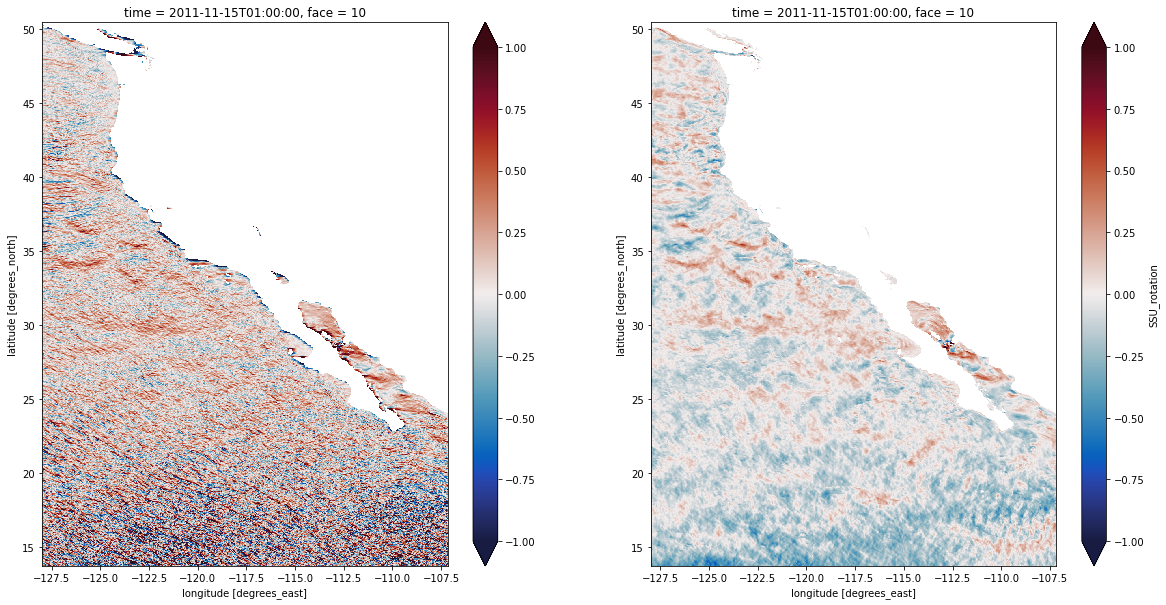

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.subplot(1,2,1)
(-dEta_dy_california/f).isel(time=1).plot(x='XC',y='YC',vmin=-1,vmax=1,cmap=cm.balance)
ax = plt.subplot(1,2,2)
SSU_rotation_california.isel(time=1).plot(x='XC',y='YC',vmin=-1,vmax=1,cmap=cm.balance)

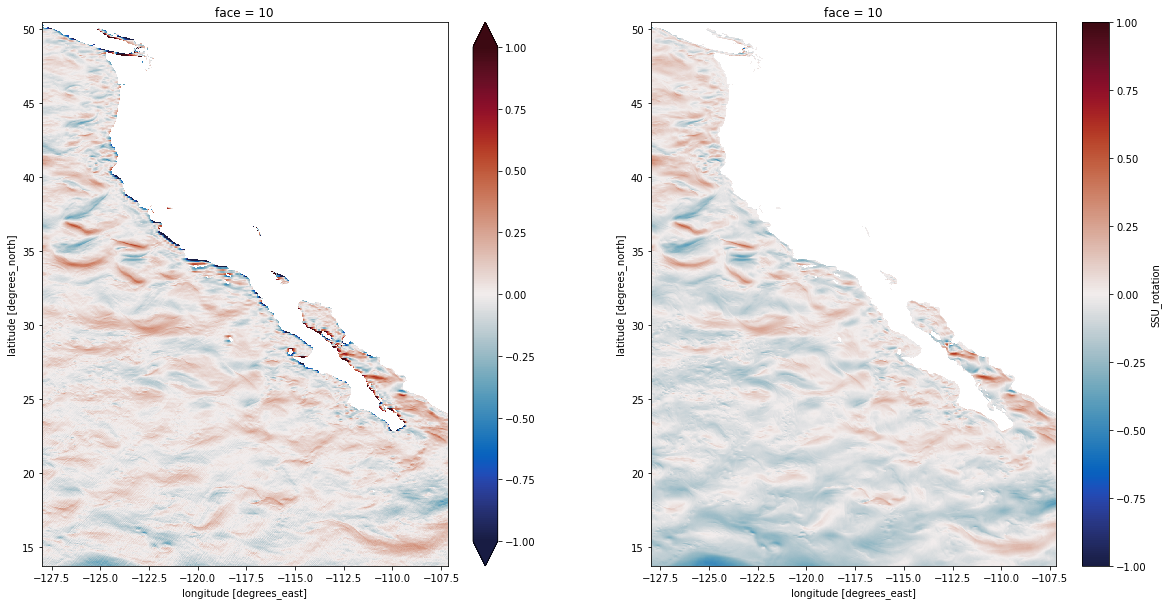

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.subplot(1,2,1)
(-dEta_dy_california/f).isel(time=slice(0,48)).mean('time').plot(x='XC',y='YC',vmin=-1,vmax=1,cmap=cm.balance)
ax = plt.subplot(1,2,2)
SSU_rotation_california.isel(time=slice(0,48)).mean('time').plot(x='XC',y='YC',vmin=-1,vmax=1,cmap=cm.balance)

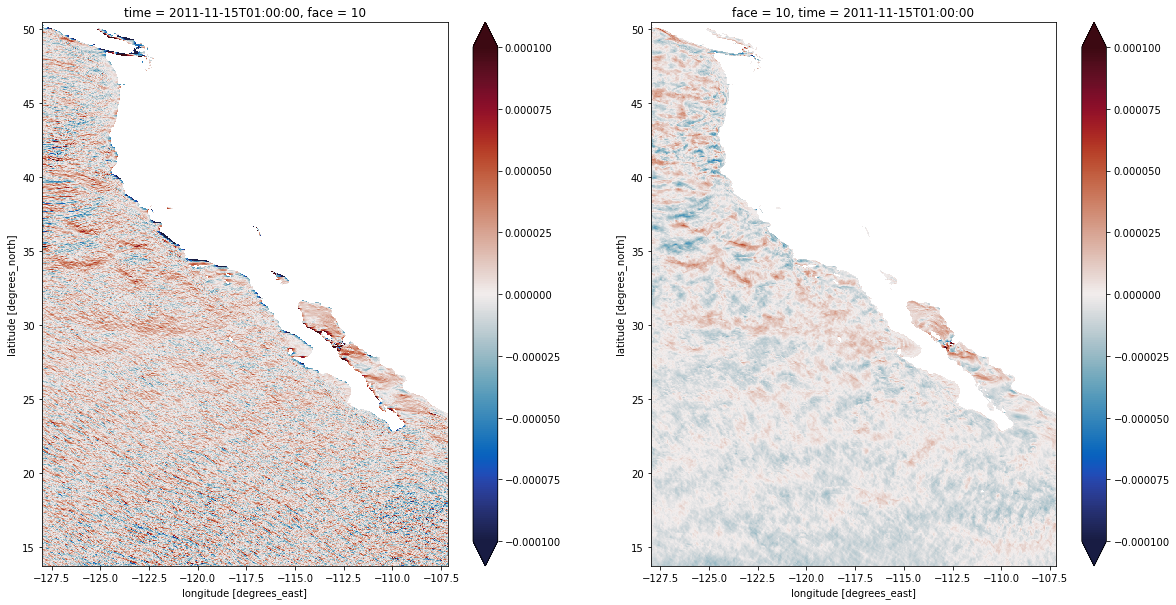

In [16]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.subplot(1,2,1)
(-dEta_dy_california).isel(time=1).plot(x='XC',y='YC',vmin=-1e-4,vmax=1e-4,cmap=cm.balance)
ax = plt.subplot(1,2,2)
(f*SSU_rotation_california).isel(time=1).plot(x='XC',y='YC',vmin=-1e-4,vmax=1e-4,cmap=cm.balance)

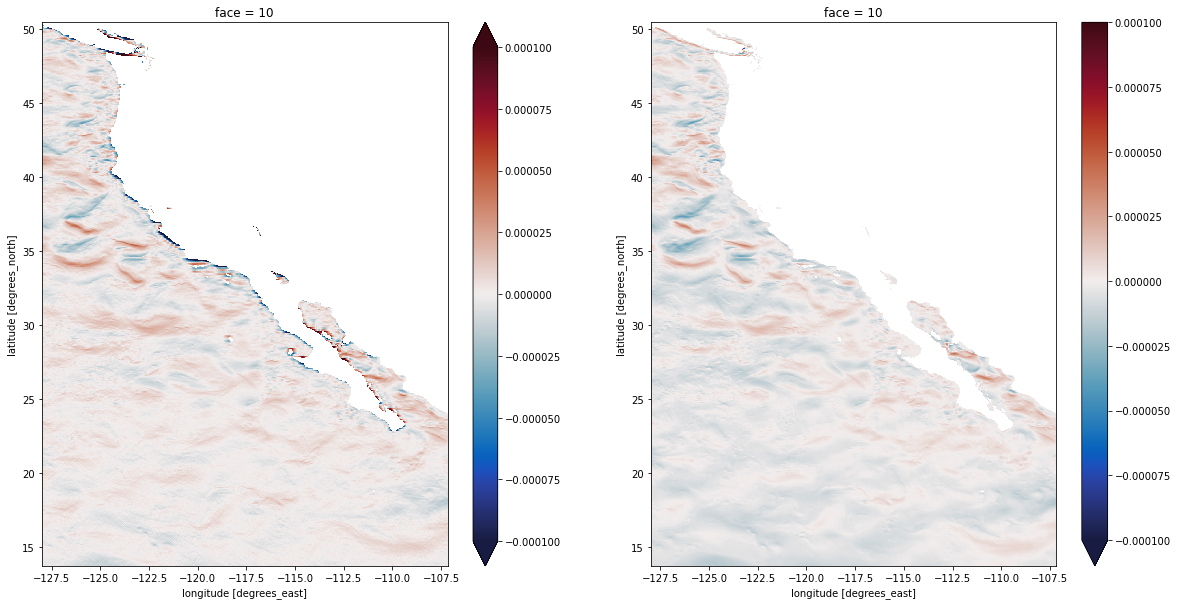

In [17]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.subplot(1,2,1)
(-dEta_dy_california).isel(time=slice(0,24)).mean('time').plot(x='XC',y='YC',vmin=-1e-4,vmax=1e-4,cmap=cm.balance)
ax = plt.subplot(1,2,2)
(f*SSU_rotation_california).isel(time=slice(0,24)).mean('time').plot(x='XC',y='YC',vmin=-1e-4,vmax=1e-4,cmap=cm.balance)

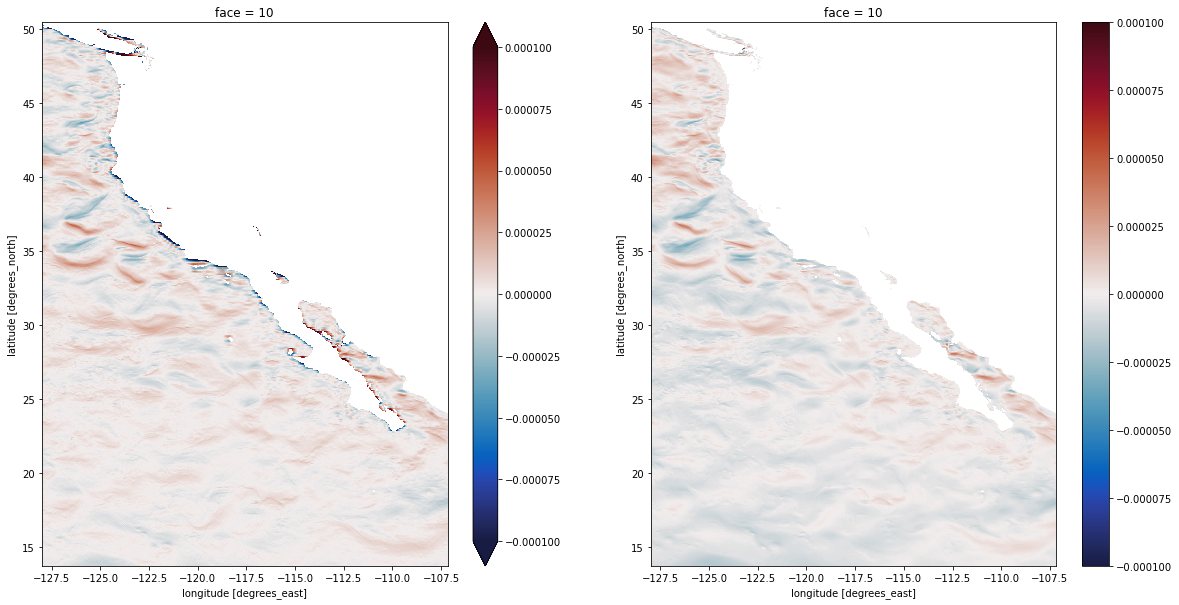

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
ax = plt.subplot(1,2,1)
(-dEta_dy_california).isel(time=slice(0,48)).mean('time').plot(x='XC',y='YC',vmin=-1e-4,vmax=1e-4,cmap=cm.balance)
ax = plt.subplot(1,2,2)
(f*SSU_rotation_california).isel(time=slice(0,48)).mean('time').plot(x='XC',y='YC',vmin=-1e-4,vmax=1e-4,cmap=cm.balance)

## Spatial filtering

In [18]:
# spatial filter
grid_num = 72
wt_Eta = ds['Eta'].isel(time=1).window
wt_Eta.set(n={'i': grid_num, 'j': grid_num}, window={'i':'hanning', 'j':'hanning'}, chunks = {'i':4320, 'j':4320})
Eta_filter = wt_Eta.convolve()
Eta_filter

<xarray.DataArray 'Eta' (j: 4320, i: 4320)>
dask.array<mul, shape=(4320, 4320), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2011-11-15T01:00:00
    face     int64 10
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    int64 dask.array<chunksize=(), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>

In [24]:
# temporal filter
time_num = 24
wt_Eta = ds['Eta'].window
wt_Eta.set(n={'time': time_num}, window={'time':'hanning'}, chunks = {'i':4320, 'j':4320, 'time':1})
Eta_filter = wt_Eta.convolve()
Eta_filter = Eta_filter.isel(time=1)
Eta_filter

<xarray.DataArray 'Eta' (j: 4320, i: 4320)>
dask.array<getitem, shape=(4320, 4320), dtype=float32, chunksize=(4320, 4320), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2011-11-15T01:00:00
    face     int64 10
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    niter    int64 dask.array<chunksize=(), meta=np.ndarray>
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
    XC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(4320, 4320), meta=np.ndarray>

In [25]:
grid = xgcm.Grid(ds, periodic=['X', 'Y'])

# sea level gradients
g = 9.81
dB_dx_raw = grid.diff(g*Eta_filter,'X')/ds.dxC 
dB_dy_raw = grid.diff(g*Eta_filter,'Y')/ds.dyC    
# interpolate back into (i,j) grids
dB_dx_raw_ij = grid.interp(dB_dx_raw,'X')
dB_dy_raw_ij = grid.interp(dB_dy_raw,'Y')
# rotation
dB_dx = dB_dx_raw_ij*ds.CS - dB_dy_raw_ij*ds.SN
dB_dy = dB_dx_raw_ij*ds.SN + dB_dy_raw_ij*ds.CS
# subdomain (California)
dEta_dy_california = dB_dy.isel(i=slice(2000,-1),j=slice(0,1000))
dEta_dy_california

<xarray.DataArray (j: 1000, i: 2319)>
dask.array<getitem, shape=(1000, 2319), dtype=float32, chunksize=(999, 2319), chunktype=numpy.ndarray>
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 ... 991 992 993 994 995 996 997 998 999
  * i        (i) int64 2000 2001 2002 2003 2004 ... 4314 4315 4316 4317 4318
    face     int64 10
    XC       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    YC       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    Depth    (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    CS       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>
    SN       (j, i) float32 dask.array<chunksize=(1000, 2319), meta=np.ndarray>

In [10]:
U_ij = grid.interp(ds['SSU'],'X')
V_ij = grid.interp(ds['SSV'],'Y')

SSU_rotation = U_ij*ds.CS - V_ij*ds.SN
SSV_rotation = U_ij*ds.SN + V_ij*ds.CS
SSU_rotation = np.real(SSU_rotation).rename('SSU_rotation')
SSV_rotation = np.real(SSV_rotation).rename('SSV_rotation')
f = ut.coriolis(ds["YC"])

SSU_rotation_california = SSU_rotation.isel(i=slice(2000,-1),j=slice(0,1000))
SSU_rotation_california

(-2.0, 2.0)

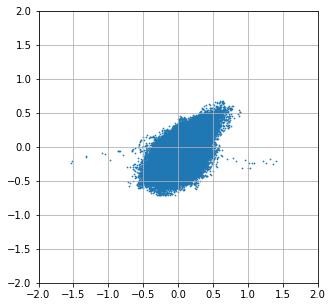

In [26]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter( -dEta_dy_california.where(dEta_dy_california.Depth>1000)/f, SSU_rotation_california.where(dEta_dy_california.Depth>1000).isel(time=1), s=.5)
ax.grid()
ax.set_xlim(-2.,2.)
ax.set_ylim(-2.,2.)

In [28]:
cluster.close()